<a href="https://colab.research.google.com/github/jameschapman19/cca_zoo/blob/master/tutorial_notebooks/cca_zoo_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cca-zoo[deep,probabilistic] --upgrade
!pip install scipy --upgrade

Requirement already up-to-date: cca-zoo[deep,probabilistic] in /usr/local/lib/python3.7/dist-packages (1.7.10)
Requirement already up-to-date: scipy in /usr/local/lib/python3.7/dist-packages (1.7.0)


In [2]:
# Imports
import numpy as np
from cca_zoo.data import Noisy_MNIST_Dataset
import itertools
import os
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch import optim
from cca_zoo.deepmodels import objectives, architectures, DeepWrapper, DCCA,DCCA_NOI,DVCCA,DCCAE,DTCCA

# Load MNIST Data
N = 500
dataset = Noisy_MNIST_Dataset(mnist_type='FashionMNIST', train=True)
ids = np.arange(min(2 * N, len(dataset)))
np.random.shuffle(ids)
train_ids, val_ids = np.array_split(ids, 2)
val_dataset = Subset(dataset, val_ids)
train_dataset = Subset(dataset, train_ids)
test_dataset = Noisy_MNIST_Dataset(mnist_type='FashionMNIST', train=False)
test_ids = np.arange(min(N, len(test_dataset)))
np.random.shuffle(test_ids)
test_dataset = Subset(test_dataset, test_ids)
train_view_1, train_view_2, train_rotations, train_OH_labels, train_labels = train_dataset.dataset.to_numpy(
    train_dataset.indices)
val_view_1, val_view_2, val_rotations, val_OH_labels, val_labels = val_dataset.dataset.to_numpy(val_dataset.indices)
test_view_1, test_view_2, test_rotations, test_OH_labels, test_labels = test_dataset.dataset.to_numpy(
    test_dataset.indices)

# Settings

# The number of latent dimensions across models
latent_dims = 2
# The number of folds used for cross-validation/hyperparameter tuning
cv_folds = 5
# For running hyperparameter tuning in parallel (0 if not)
jobs = 2
# Number of iterations for iterative algorithms
max_iter = 2
# number of epochs for deep models
epochs = 50

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Canonical Correlation Analysis

In [3]:
from cca_zoo.models import CCA, CCA_ALS
"""
### Linear CCA by eigendecomposition
"""
linear_cca = CCA(latent_dims=latent_dims)

linear_cca.fit(train_view_1, train_view_2)

linear_cca_results = np.stack(
    (linear_cca.train_correlations[0, 1], linear_cca.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### Linear CCA by alternating least squares (can pass more than 2 views)
"""

linear_cca_als = CCA_ALS(latent_dims=latent_dims)

linear_cca_als.fit(train_view_1, train_view_2)

linear_cca_als_results = np.stack(
    (linear_cca_als.train_correlations[0, 1], linear_cca_als.predict_corr(test_view_1, test_view_2)[0, 1]))

# Partial Least Squares


In [4]:
from cca_zoo.models import PLS
"""
### PLS with scikit-learn (only permits 2 views)
"""
pls = PLS(latent_dims=latent_dims)

pls.fit(train_view_1, train_view_2)

pls_results = np.stack(
    (pls.train_correlations[0, 1], pls.predict_corr(test_view_1, test_view_2)[0, 1]))

# Extension to multiple views



In [5]:
from cca_zoo.models import GCCA, MCCA
"""
### (Regularized) Generalized CCA(can pass more than 2 views)
"""
# small ammount of regularisation added since data is not full rank
c=[0.5,0.5,0.5]

gcca = GCCA(latent_dims=latent_dims,c=c)

gcca.fit(train_view_1, train_view_2,train_view_1)

gcca_results = np.stack((gcca.train_correlations[0, 1], gcca.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### (Regularized) Multiset CCA(can pass more than 2 views)
"""

mcca = MCCA(latent_dims=latent_dims, c=c)

mcca.fit(train_view_1, train_view_2,train_view_1)

mcca_results = np.stack((mcca.train_correlations[0, 1], mcca.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### Multiset CCA by alternating least squares
"""
mcca_als = CCA_ALS(latent_dims=latent_dims, max_iter=max_iter)

mcca_als.fit(train_view_1, train_view_2,train_view_1)

mcca_als_results = np.stack(
    (mcca_als.train_correlations[0, 1], mcca_als.predict_corr(test_view_1, test_view_2)[0, 1]))

"""
### Multiset PLS by alternating least squares
"""
mcca_pls = PLS(latent_dims=latent_dims, max_iter=max_iter)

mcca_pls.fit(train_view_1, train_view_2,train_view_1)

mcca_pls_results = np.stack(
    (mcca_als.train_correlations[0, 1], mcca_pls.predict_corr(test_view_1, test_view_2)[0, 1]))

/usr/local/lib/python3.7/dist-packages/cca_zoo/models/innerloop.py:53: UserWarning: For more than 2 views require generalized=True
  'For more than 2 views require generalized=True')
/usr/local/lib/python3.7/dist-packages/cca_zoo/models/innerloop.py:53: UserWarning: For more than 2 views require generalized=True
  'For more than 2 views require generalized=True')
/usr/local/lib/python3.7/dist-packages/cca_zoo/models/innerloop.py:53: UserWarning: For more than 2 views require generalized=True
  'For more than 2 views require generalized=True')


# Tensor CCA

In [6]:
from cca_zoo.models import TCCA
"""
### (Regularized) Tensor CCA(can pass more than 2 views)
"""

tcca = TCCA(latent_dims=latent_dims, c=c)

tcca.fit(train_view_1[:,:100], train_view_2[:,:100],train_view_1[:,:100])

tcca_results = np.stack((tcca.train_correlations[0, 1], tcca.predict_corr(test_view_1[:,:100], test_view_2[:,:100])[0, 1]))

reconstruction error=0.9832184437980438
iteration 1, reconstruction error: 0.9809724096593291, decrease = 0.0022460341387147142, unnormalized = 0.009848200644192581
iteration 2, reconstruction error: 0.9806865660160673, decrease = 0.000285843643261785, unnormalized = 0.009845330996153564
iteration 3, reconstruction error: 0.9806725005190556, decrease = 1.4065497011661598e-05, unnormalized = 0.009845189789494368
iteration 4, reconstruction error: 0.980671706909605, decrease = 7.936094506000302e-07, unnormalized = 0.009845181822272226
iteration 5, reconstruction error: 0.9806716346058121, decrease = 7.230379295286582e-08, unnormalized = 0.009845181096398335
iteration 6, reconstruction error: 0.9806716267809321, decrease = 7.824879966200626e-09, unnormalized = 0.009845181017842621
PARAFAC converged after 6 iterations


# Weighted GCCA/Missing Observation GCCA

In [7]:
#observation_matrix
K = np.ones((3, N))
K[0, 200:] = 0
K[1, :100] = 0

#view weights
view_weights=[1,2,1.2]

c=[0.5,0.5,0.5]

gcca = GCCA(latent_dims=latent_dims,c=c,view_weights=view_weights)

gcca.fit(train_view_1, train_view_2,train_view_1,K=K)

gcca_results = np.stack((gcca.train_correlations[0, 1], gcca.predict_corr(test_view_1, test_view_2)[0, 1]))

# Rgularised CCA solutions based on alternating minimisation/alternating least squares

We implement Witten's penalized matrix decomposition form of sparse CCA using 'pmd'

We implement Waaijenborg's penalized CCA using elastic net using 'elastic'

We implement Mai's sparse CCA using 'scca'

Furthermore, any of these methods can be extended to multiple views. Witten describes this method explicitly.

cross validation
number of folds:  5
Best score :  1.2801839915870752
Standard deviation :  0.08658094698557009
{'c': (0.9, 0.7)}
cross validation
number of folds:  5
Best score :  1.2199984187456505
Standard deviation :  0.11744899205905167
{'c': (9, 9)}
cross validation
number of folds:  5
Best score :  0.7760989180072052
Standard deviation :  0.038838728302815345
{'c': (0.0001, 0.0001)}
cross validation
number of folds:  5
Best score :  0.9750176062812855
Standard deviation :  0.09765594875657732
{'c': (0.001, 0.0001), 'l1_ratio': (0.1, 0.01)}


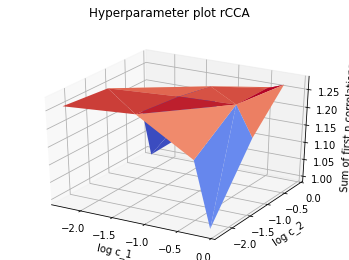

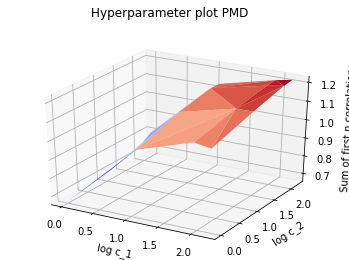

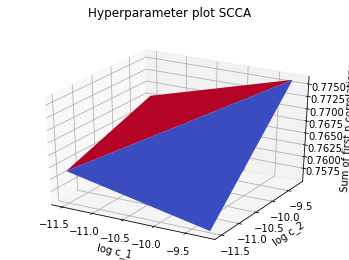

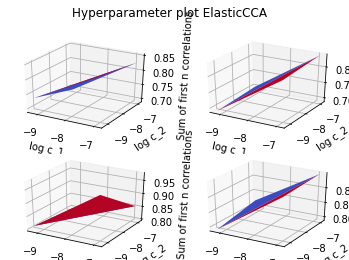

In [8]:
from cca_zoo.models import rCCA, PMD,SCCA,ElasticCCA
"""
### Ridge CCA (can pass more than 2 views)
"""
c1 = [0.1, 0.3, 0.7, 0.9]
c2 = [0.1, 0.3, 0.7, 0.9]
param_candidates = {'c': list(itertools.product(c1, c2))}

ridge = rCCA(latent_dims=latent_dims).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True, jobs=jobs,
    plot=True)

ridge_results = np.stack((ridge.train_correlations[0, 1, :], ridge.predict_corr(test_view_1, test_view_2)[0, 1, :]))

"""
### Sparse CCA (Penalized Matrix Decomposition) (can pass more than 2 views)
"""

# PMD
c1 = [1, 3, 7, 9]
c2 = [1, 3, 7, 9]
param_candidates = {'c': list(itertools.product(c1, c2))}

pmd = PMD(latent_dims=latent_dims, max_iter=max_iter).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True, jobs=jobs,
    plot=True)

pmd_results = np.stack((pmd.train_correlations[0, 1, :], pmd.predict_corr(test_view_1, test_view_2)[0, 1, :]))

"""
### Sparse CCA (can pass more than 2 views)
"""

# Sparse CCA
c1 = [0.00001, 0.0001]
c2 = [0.00001, 0.0001]
param_candidates = {'c': list(itertools.product(c1, c2))}

scca = SCCA(latent_dims=latent_dims, max_iter=max_iter).gridsearch_fit(
    train_view_1,
    train_view_2,
    param_candidates=param_candidates,
    folds=cv_folds,
    verbose=True,
    jobs=jobs, plot=True)

scca_results = np.stack(
    (scca.train_correlations[0, 1, :], scca.predict_corr(test_view_1, test_view_2)[0, 1, :]))


"""
### Elastic CCA (can pass more than 2 views)
"""

# Elastic CCA
c1 = [0.001, 0.0001]
c2 = [0.001, 0.0001]
l1_1 = [0.01, 0.1]
l1_2 = [0.01, 0.1]
param_candidates = {'c': list(itertools.product(c1, c2)), 'l1_ratio': list(itertools.product(l1_1, l1_2))}

elastic = ElasticCCA(latent_dims=latent_dims,
                              max_iter=max_iter).gridsearch_fit(train_view_1,
                                                                train_view_2,
                                                                param_candidates=param_candidates,
                                                                folds=cv_folds,
                                                                verbose=True,
                                                                jobs=jobs,
                                                                plot=True)

elastic_results = np.stack(
    (elastic.train_correlations[0, 1, :], elastic.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# Kernel CCA

cross validation
number of folds:  5
Best score :  1.369923491569789
Standard deviation :  0.04365876645226254
{'kernel': ['linear', 'linear'], 'c': (0.99, 0.99)}
cross validation
number of folds:  5
Best score :  1.4256819824673677
Standard deviation :  0.1026144716340678
{'kernel': ['poly', 'poly'], 'degree': (3, 3), 'c': (0.9, 0.9)}
cross validation
number of folds:  5
Best score :  0.0
Standard deviation :  0.0
{'kernel': ['rbf', 'rbf'], 'gamma': (10.0, 10.0), 'c': (0.9, 0.9)}


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


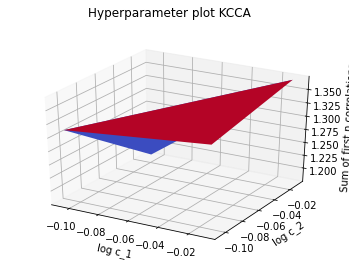

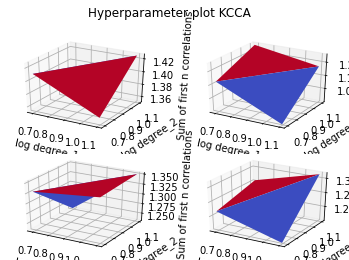

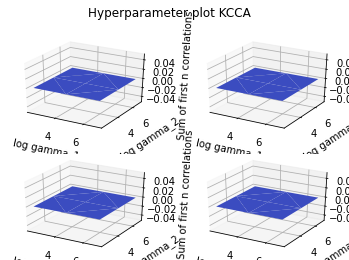

In [9]:
from cca_zoo.models import KCCA
"""
### Kernel CCA

Similarly, we can use kernel CCA methods with [method='kernel']

We can use different kernels and their associated parameters in a similar manner to before
- regularized linear kernel CCA: parameters :  'kernel'='linear', 0<'c'<1
- polynomial kernel CCA: parameters : 'kernel'='poly', 'degree', 0<'c'<1
- gaussian rbf kernel CCA: parameters : 'kernel'='gaussian', 'sigma', 0<'c'<1
"""
# %%
# r-kernel cca
c1 = [0.9, 0.99]
c2 = [0.9, 0.99]

param_candidates = {'kernel': [['linear', 'linear']], 'c': list(itertools.product(c1, c2))}

kernel_reg = KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                          folds=cv_folds,
                                                          param_candidates=param_candidates,
                                                          verbose=True, jobs=jobs,
                                                          plot=True)
kernel_reg_results = np.stack((
    kernel_reg.train_correlations[0, 1, :],
    kernel_reg.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# kernel cca (poly)
degree1 = [2, 3]
degree2 = [2, 3]

param_candidates = {'kernel': [['poly', 'poly']], 'degree': list(itertools.product(degree1, degree2)),
                    'c': list(itertools.product(c1, c2))}

kernel_poly = KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                           folds=cv_folds,
                                                           param_candidates=param_candidates,
                                                           verbose=True, jobs=jobs,
                                                           plot=True)

kernel_poly_results = np.stack((
    kernel_poly.train_correlations[0, 1, :],
    kernel_poly.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# kernel cca (gaussian)
gamma1 = [1e+1, 1e+2, 1e+3]
gamma2 = [1e+1, 1e+2, 1e+3]

param_candidates = {'kernel': [['rbf', 'rbf']], 'gamma': list(itertools.product(gamma1, gamma2)),
                    'c': list(itertools.product(c1, c2))}

kernel_gaussian = KCCA(latent_dims=latent_dims).gridsearch_fit(train_view_1, train_view_2,
                                                               folds=cv_folds,
                                                               param_candidates=param_candidates,
                                                               verbose=True, jobs=jobs,
                                                               plot=True)

kernel_gaussian_results = np.stack((
    kernel_gaussian.train_correlations[0, 1, :],
    kernel_gaussian.predict_corr(test_view_1, test_view_2)[0, 1, :]))

# Deep CCA

DCCA can be optimized using Andrew's original tracenorm objective or Wang's DCCA by nonlinear orthogonal iterations using the argument als=True.

In [12]:
"""
### Deep Learning

We also have deep CCA methods (and autoencoder variants)
- Deep CCA (DCCA)
- Deep Canonically Correlated Autoencoders (DCCAE)

We introduce a Config class from configuration.py. This contains a number of default settings for running 

"""

# %%
# DCCA
print('DCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dcca_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])
#by default DeepWrapper uses the LBFGS optimizer from Andrew 2013 original work
dcca_model = DeepWrapper(dcca_model)

dcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=20)
#could also call using tuple of numpy arrays as follows:
#dcca_model.fit((train_view_1,train_view_2), val_dataset=(val_view_1,val_view_2), epochs=epochs)

dcca_results = np.stack((dcca_model.train_correlations[0, 1], dcca_model.predict_corr(test_dataset)[0, 1]))

# DCCA_NOI
print('DCCA by non-linear orthogonal iterations')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dcca_noi_model = DCCA_NOI(latent_dims=latent_dims, encoders=[encoder_1, encoder_2],N=len(train_dataset))
optimizer = optim.Adam(dcca_noi_model.parameters(), lr=1e-4)
dcca_noi_model = DeepWrapper(dcca_noi_model, optimizer=optimizer)

dcca_noi_model.fit(train_dataset, val_dataset=val_dataset, epochs=20)

dcca_noi_results = np.stack(
    (dcca_noi_model.train_correlations[0, 1], dcca_noi_model.predict_corr(test_dataset)[0, 1]))

DCCA
total parameters:  201476
====> Epoch: 1 Average train loss: -1.2384
====> Epoch: 1 Average val loss: -1.1769
Min loss -1.18
====> Epoch: 2 Average train loss: -1.1906
====> Epoch: 2 Average val loss: -1.1457
====> Epoch: 3 Average train loss: -1.1447
====> Epoch: 3 Average val loss: -1.2003
Min loss -1.20
====> Epoch: 4 Average train loss: -1.1863
====> Epoch: 4 Average val loss: -1.2088
Min loss -1.21
====> Epoch: 5 Average train loss: -1.2620
====> Epoch: 5 Average val loss: -1.2163
Min loss -1.22
====> Epoch: 6 Average train loss: -1.2198
====> Epoch: 6 Average val loss: -1.3061
Min loss -1.31
====> Epoch: 7 Average train loss: -1.3731
====> Epoch: 7 Average val loss: -1.3156
Min loss -1.32
====> Epoch: 8 Average train loss: -1.2878
====> Epoch: 8 Average val loss: -1.3892
Min loss -1.39
====> Epoch: 9 Average train loss: -1.3810
====> Epoch: 9 Average val loss: -1.3726
====> Epoch: 10 Average train loss: -1.3473
====> Epoch: 10 Average val loss: -1.3609
====> Epoch: 11 Averag

# DCCA with custom optimizers and schedulers

In [13]:
# DCCA
dcca_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2],
                                objective=objectives.CCA)
optimizer = optim.Adam(dcca_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 1)
# hidden_layer_sizes are shown explicitly but these are also the defaults
dcca_model = DeepWrapper(dcca_model,optimizer=optimizer,scheduler=scheduler)
dcca_model.fit(train_dataset, val_dataset=val_dataset,epochs=20)

total parameters:  201476
====> Epoch: 1 Average train loss: -0.0425
====> Epoch: 1 Average val loss: -0.0343
Min loss -0.03
====> Epoch: 2 Average train loss: -0.0539
====> Epoch: 2 Average val loss: -0.1114
Min loss -0.11
====> Epoch: 3 Average train loss: -0.0382
====> Epoch: 3 Average val loss: -0.1074
====> Epoch: 4 Average train loss: -0.1808
====> Epoch: 4 Average val loss: -0.0957
====> Epoch: 5 Average train loss: -0.1531
====> Epoch: 5 Average val loss: -0.2483
Min loss -0.25
====> Epoch: 6 Average train loss: -0.2803
====> Epoch: 6 Average val loss: -0.2800
Min loss -0.28
====> Epoch: 7 Average train loss: -0.2660
====> Epoch: 7 Average val loss: -0.3304
Min loss -0.33
====> Epoch: 8 Average train loss: -0.4727
====> Epoch: 8 Average val loss: -0.4029
Min loss -0.40
====> Epoch: 9 Average train loss: -0.3634
====> Epoch: 9 Average val loss: -0.4618
Min loss -0.46
====> Epoch: 10 Average train loss: -0.4526
====> Epoch: 10 Average val loss: -0.4343
====> Epoch: 11 Average tra

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


DeepWrapper(clip_value=inf, device='cpu', lr=None,
            model=DCCA(
  (encoders): ModuleList(
    (0): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
          (1): ReLU()
        )
      )
      (fc): Linear(in_features=128, out_features=2, bias=True)
    )
    (1): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=128, bias=True)
          (1): ReLU()
        )
      )
      (fc): Linear(in_features=128, out_features=2, bias=True)
    )
  )
),
            optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    weight_decay: 0
),
            scheduler=<torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7fab437ed490>,
            tensorboard=False, tensorboard_tag=None)

# DGCCA and DMCCA for more than 2 views

The only change we need to make is to the objective argument to perform DGCCA and DMCCA.

In [14]:
# DGCCA
print('DGCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dgcca_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], objective=objectives.GCCA)
optimizer = optim.Adam(dgcca_model.parameters(), lr=1e-4)
dgcca_model = DeepWrapper(dgcca_model, optimizer=optimizer)

dgcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=20)

dgcca_results = np.stack(
    (dgcca_model.train_correlations[0, 1], dgcca_model.predict_corr(test_dataset)[0, 1]))

# DMCCA
print('DMCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dmcca_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], objective=objectives.MCCA)
optimizer = optim.Adam(dmcca_model.parameters(), lr=1e-4)
dmcca_model = DeepWrapper(dmcca_model, optimizer=optimizer)

dmcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=20)

dmcca_results = np.stack(
    (dmcca_model.train_correlations[0, 1], dmcca_model.predict_corr(test_dataset)[0, 1]))

DGCCA
total parameters:  201476
====> Epoch: 1 Average train loss: -0.1891
====> Epoch: 1 Average val loss: -0.3337
Min loss -0.33
====> Epoch: 2 Average train loss: -0.2927
====> Epoch: 2 Average val loss: -0.5799
Min loss -0.58
====> Epoch: 3 Average train loss: -0.5377
====> Epoch: 3 Average val loss: -0.6556
Min loss -0.66
====> Epoch: 4 Average train loss: -0.6376
====> Epoch: 4 Average val loss: -0.8403
Min loss -0.84
====> Epoch: 5 Average train loss: -0.8906
====> Epoch: 5 Average val loss: -1.0104
Min loss -1.01
====> Epoch: 6 Average train loss: -1.0079
====> Epoch: 6 Average val loss: -1.0361
Min loss -1.04
====> Epoch: 7 Average train loss: -1.0182
====> Epoch: 7 Average val loss: -1.0547
Min loss -1.05
====> Epoch: 8 Average train loss: -1.0915
====> Epoch: 8 Average val loss: -1.1475
Min loss -1.15
====> Epoch: 9 Average train loss: -1.1349
====> Epoch: 9 Average val loss: -1.1514
Min loss -1.15
====> Epoch: 10 Average train loss: -1.1461
====> Epoch: 10 Average val loss:

# Deep Canonically Correlated Autoencoders
We need to add decoders in order to model deep canonically correlated autoencoders and we also use the DCCAE class which inherits from DCCA

In [15]:
# DCCAE
print('DCCAE')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
decoder_1 = architectures.Decoder(latent_dims=latent_dims, feature_size=784)
decoder_2 = architectures.Decoder(latent_dims=latent_dims, feature_size=784)
dccae_model = DCCAE(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2])
optimizer = optim.Adam(dccae_model.parameters(), lr=1e-4)
dccae_model = DeepWrapper(dccae_model, optimizer=optimizer)

#can also pass a tuple of numpy arrays
dccae_model.fit((train_view_1, train_view_2), epochs=epochs)

dccae_results = np.stack(
    (dccae_model.train_correlations[0, 1], dccae_model.predict_corr(test_dataset)[0, 1]))

DCCAE
total parameters:  404516
====> Epoch: 1 Average train loss: 0.1387
====> Epoch: 2 Average train loss: -0.1681
====> Epoch: 3 Average train loss: -0.3927
====> Epoch: 4 Average train loss: -0.5572
====> Epoch: 5 Average train loss: -0.6793
====> Epoch: 6 Average train loss: -0.7728
====> Epoch: 7 Average train loss: -0.8440
====> Epoch: 8 Average train loss: -0.9009
====> Epoch: 9 Average train loss: -0.9484
====> Epoch: 10 Average train loss: -0.9887
====> Epoch: 11 Average train loss: -1.0238
====> Epoch: 12 Average train loss: -1.0551
====> Epoch: 13 Average train loss: -1.0843
====> Epoch: 14 Average train loss: -1.1118
====> Epoch: 15 Average train loss: -1.1378
====> Epoch: 16 Average train loss: -1.1628
====> Epoch: 17 Average train loss: -1.1869
====> Epoch: 18 Average train loss: -1.2102
====> Epoch: 19 Average train loss: -1.2327
====> Epoch: 20 Average train loss: -1.2545
====> Epoch: 21 Average train loss: -1.2757
====> Epoch: 22 Average train loss: -1.2959
====> Epoc

# Deep Variational CCA

In [19]:
"""
### Deep Variational Learning
Finally we have Deep Variational CCA methods.
- Deep Variational CCA (DVCCA)
- Deep Variational CCA - private (DVVCA_p)

These are both implemented by the DVCCA class with private=True/False and both_encoders=True/False. If both_encoders,
the encoder to the shared information Q(z_shared|x) is modelled for both x_1 and x_2 whereas if both_encoders is false
it is modelled for x_1 as in the paper
"""

# %%
# DVCCA (technically bi-DVCCA)
print('DVCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
#Need normalized outputs for VCCA
decoder_1 = architectures.Decoder(latent_dims=latent_dims, feature_size=784, norm_output=True)
decoder_2 = architectures.Decoder(latent_dims=latent_dims, feature_size=784, norm_output=True)
dvcca_model = DVCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2])

dvcca_model = DeepWrapper(dvcca_model)

dvcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dvcca_model_results = np.stack(
    (dvcca_model.train_correlations[0, 1], dvcca_model.predict_corr(test_dataset)[0, 1]))

# DVCCA_private (technically bi-DVCCA_private)
print('DVCCA_private')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
private_encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
private_encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784, variational=True)
#Need normalized outputs for VCCA
decoder_1 = architectures.Decoder(latent_dims=latent_dims * 2, feature_size=784, norm_output=True)
decoder_2 = architectures.Decoder(latent_dims=latent_dims * 2, feature_size=784, norm_output=True)
dvccap_model = DVCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2], decoders=[decoder_1, decoder_2],
                           private_encoders=[private_encoder_1, private_encoder_2])

dvccap_model = DeepWrapper(dvccap_model)

dvccap_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dvccap_model_results = np.stack(
    (dvccap_model.train_correlations[0, 1], dvccap_model.predict_corr(test_dataset)[0, 1]))

DVCCA
total parameters:  405032
====> Epoch: 1 Average train loss: 1110.4732
====> Epoch: 1 Average val loss: 1106.4142
Min loss 1106.41
====> Epoch: 2 Average train loss: 1106.5694
====> Epoch: 2 Average val loss: 1102.5826
Min loss 1102.58
====> Epoch: 3 Average train loss: 1102.6800
====> Epoch: 3 Average val loss: 1098.6781
Min loss 1098.68
====> Epoch: 4 Average train loss: 1098.8508
====> Epoch: 4 Average val loss: 1094.8165
Min loss 1094.82
====> Epoch: 5 Average train loss: 1095.0506
====> Epoch: 5 Average val loss: 1091.2413
Min loss 1091.24
====> Epoch: 6 Average train loss: 1091.3015
====> Epoch: 6 Average val loss: 1087.4451
Min loss 1087.45
====> Epoch: 7 Average train loss: 1087.4797
====> Epoch: 7 Average val loss: 1083.9051
Min loss 1083.91
====> Epoch: 8 Average train loss: 1083.9555
====> Epoch: 8 Average val loss: 1080.3689
Min loss 1080.37
====> Epoch: 9 Average train loss: 1080.4118
====> Epoch: 9 Average val loss: 1076.7197
Min loss 1076.72
====> Epoch: 10 Average

# Convolutional Deep CCA (and using other architectures)
We provide a standard CNN encoder and decoder but users can build their own encoders and decoders by inheriting BaseEncoder and BaseDecoder for seamless integration with the pipeline

In [20]:
print('Convolutional DCCA')
encoder_1 = architectures.CNNEncoder(latent_dims=latent_dims, channels=[3, 3])
encoder_2 = architectures.CNNEncoder(latent_dims=latent_dims, channels=[3, 3])
dcca_conv_model = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])
optimizer = optim.Adam(dcca_conv_model.parameters(), lr=1e-4)
dcca_conv_model = DeepWrapper(dcca_conv_model, optimizer = optimizer)

# to change the models used change the cfg.encoder_models. We implement a CNN_Encoder and CNN_decoder as well
# as some based on brainnet architecture in cca_zoo.architectures. Equally you could pass your own encoder/decoder models

dcca_conv_model.fit((train_view_1.reshape((-1, 1, 28, 28)), train_view_2.reshape((-1, 1, 28, 28))), epochs=epochs)

dcca_conv_results = np.stack(
    (dcca_conv_model.train_correlations[0, 1], dcca_conv_model.predict_corr((test_view_1.reshape((-1, 1, 28, 28)),
                                                                            test_view_2.reshape(
                                                                                (-1, 1, 28, 28))))[0, 1]))

Convolutional DCCA
total parameters:  9568
====> Epoch: 1 Average train loss: -0.1200
====> Epoch: 2 Average train loss: -0.1673
====> Epoch: 3 Average train loss: -0.2140
====> Epoch: 4 Average train loss: -0.2599
====> Epoch: 5 Average train loss: -0.3046
====> Epoch: 6 Average train loss: -0.3480
====> Epoch: 7 Average train loss: -0.3898
====> Epoch: 8 Average train loss: -0.4303
====> Epoch: 9 Average train loss: -0.4695
====> Epoch: 10 Average train loss: -0.5075
====> Epoch: 11 Average train loss: -0.5444
====> Epoch: 12 Average train loss: -0.5805
====> Epoch: 13 Average train loss: -0.6159
====> Epoch: 14 Average train loss: -0.6506
====> Epoch: 15 Average train loss: -0.6846
====> Epoch: 16 Average train loss: -0.7179
====> Epoch: 17 Average train loss: -0.7508
====> Epoch: 18 Average train loss: -0.7829
====> Epoch: 19 Average train loss: -0.8143
====> Epoch: 20 Average train loss: -0.8449
====> Epoch: 21 Average train loss: -0.8749
====> Epoch: 22 Average train loss: -0.904

# DTCCA

In [24]:

# %%
# DTCCA
print('DTCCA')
encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=784)
dtcca_model = DTCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])
optimizer= optim.Adam(dtcca_model.parameters(), lr=1e-4)
dtcca_model = DeepWrapper(dtcca_model,optimizer=optimizer)

dtcca_model.fit(train_dataset, val_dataset=val_dataset, epochs=epochs)

dtcca_results = np.stack((dtcca_model.train_correlations[0, 1], dtcca_model.predict_corr(test_dataset)[0, 1]))

DTCCA
total parameters:  201476


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


====> Epoch: 1 Average train loss: 0.0000
====> Epoch: 1 Average val loss: 0.0000
Min loss 0.00
====> Epoch: 2 Average train loss: 0.0000
====> Epoch: 2 Average val loss: 0.0000
====> Epoch: 3 Average train loss: 0.0000
====> Epoch: 3 Average val loss: 0.0000
====> Epoch: 4 Average train loss: 0.0000
====> Epoch: 4 Average val loss: 0.0000
====> Epoch: 5 Average train loss: 0.0000
====> Epoch: 5 Average val loss: 0.0000
====> Epoch: 6 Average train loss: 0.0000
====> Epoch: 6 Average val loss: 0.0000
Min loss 0.00
====> Epoch: 7 Average train loss: 0.0000
====> Epoch: 7 Average val loss: 0.0000
====> Epoch: 8 Average train loss: 0.0000
====> Epoch: 8 Average val loss: 0.0000
====> Epoch: 9 Average train loss: 0.0000
====> Epoch: 9 Average val loss: 0.0000
====> Epoch: 10 Average train loss: 0.0000
====> Epoch: 10 Average val loss: 0.0000
====> Epoch: 11 Average train loss: 0.0000
====> Epoch: 11 Average val loss: 0.0000
====> Epoch: 12 Average train loss: 0.0000
====> Epoch: 12 Average

# Generate Some Plots

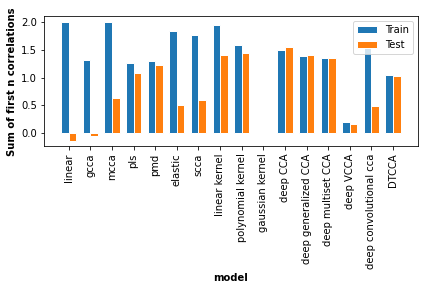

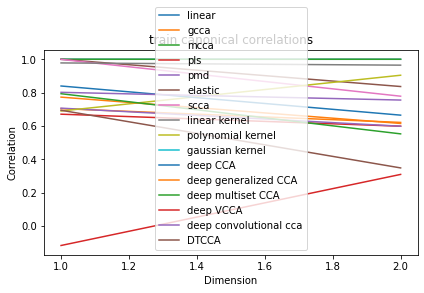

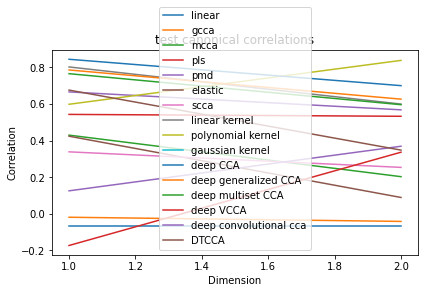

In [26]:
"""
### Make results plot to compare methods
"""
# %%

all_results = np.stack(
    [linear_cca_results, gcca_results, mcca_results, pls_results, pmd_results, elastic_results,
     scca_results, kernel_reg_results, kernel_poly_results,
     kernel_gaussian_results, dcca_results, dgcca_results, dmcca_results, dvcca_model_results,
     dcca_conv_results, dtcca_results],
    axis=0)
all_labels = ['linear', 'gcca', 'mcca', 'pls', 'pmd', 'elastic', 'scca', 'linear kernel', 'polynomial kernel',
              'gaussian kernel', 'deep CCA', 'deep generalized CCA', 'deep multiset CCA', 'deep VCCA',
              'deep convolutional cca', 'DTCCA']

from cca_zoo.utils.plot_utils import plot_results

plot_results(all_results, all_labels)
plt.show()